In [107]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## imorting Data 

In [108]:
frozen_data = pd.read_csv("resources/Frozen_Dessert_Production.csv", parse_dates = True, index_col="DATE")

In [109]:
frozen_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


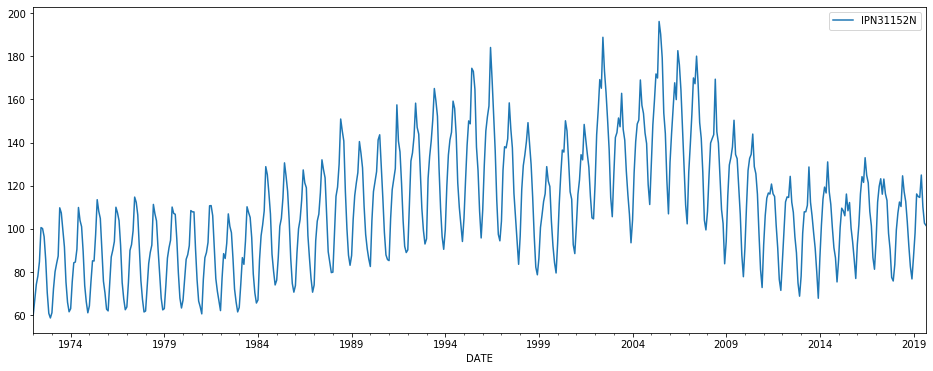

In [110]:
frozen_data.plot(figsize = (16,6))

In [111]:
len(frozen_data)

573

In [112]:
573 / 12

47.75

### Above we have 573 months (50 years) approximately  of frozen good sales so we will use at least 10 years to tain

In [113]:
test_size = 30

In [114]:
test_index = len(frozen_data) - test_size

In [115]:
train = frozen_data.iloc[:test_index]

In [116]:
test = frozen_data.iloc[test_index:]

In [117]:
train.shape

(543, 1)

In [118]:
test.shape

(30, 1)

#### Scaling the Data

In [119]:
from sklearn.preprocessing import MinMaxScaler

In [120]:
scalar = MinMaxScaler()

In [121]:
train_scaled = scalar.fit_transform(train)

In [122]:
train_scaled.shape

(543, 1)

In [123]:
test_scaled = scalar.transform(test)

In [124]:
test_scaled.shape

(30, 1)

### Time Series Generator

In [125]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [126]:
length = 6
## Aiming to predict 3 months out

In [127]:
gen = TimeseriesGenerator (
     train_scaled,
    train_scaled,
    length=length,
    batch_size= 1
)

In [128]:
x,y = gen[0]

In [129]:
x

array([[[0.00947104],
        [0.06108982],
        [0.11326273],
        [0.14145625],
        [0.18982663],
        [0.30495972]]])

In [130]:
y

array([[0.30154406]])

## Validation Generator

In [131]:
val_gen = TimeseriesGenerator(test_scaled,test_scaled, batch_size=1, length= length)

### Early Stopping

In [132]:
from tensorflow.keras.callbacks import EarlyStopping

In [133]:
stop = EarlyStopping(monitor="val_loss", mode="min", patience=4)

### Model Creation 

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [135]:
n_features = 1
## Attempting to predice 1 feature

In [136]:
model = Sequential()
model.add(LSTM(units = 250, activation = "relu", input_shape = (length, n_features)))
model.add(Dense(units = (1)))
model.compile(optimizer = "adam", loss = "mse")

### Fitting the model

In [137]:
model.fit_generator(gen, validation_data=val_gen, epochs=15, callbacks=[stop])

Epoch 1/15
537/537 [==============================] - 127s 236ms/step - loss: 0.0276 - val_loss: 0.0080
Epoch 2/15
537/537 [==============================] - 126s 235ms/step - loss: 0.0126 - val_loss: 0.0051
Epoch 3/15
537/537 [==============================] - 130s 242ms/step - loss: 0.0084 - val_loss: 0.0049
Epoch 4/15
537/537 [==============================] - 134s 250ms/step - loss: 0.0059 - val_loss: 0.0031
Epoch 5/15
537/537 [==============================] - 129s 241ms/step - loss: 0.0059 - val_loss: 0.0031
Epoch 6/15
537/537 [==============================] - 129s 240ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 7/15
537/537 [==============================] - 135s 251ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 8/15
537/537 [==============================] - 129s 241ms/step - loss: 0.0049 - val_loss: 0.0024
Epoch 9/15
537/537 [==============================] - 129s 240ms/step - loss: 0.0046 - val_loss: 0.0032
Epoch 10/15
537/537 [==============================] - 137s 256m

## Evaluating model

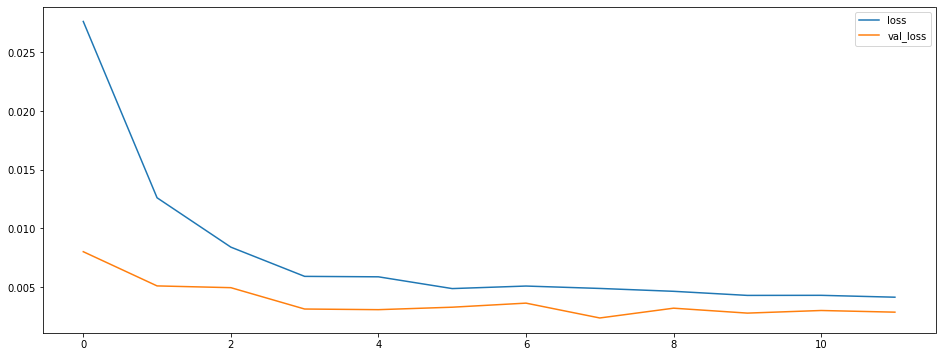

In [138]:
pd.DataFrame(model.history.history).plot(figsize = (16,6))

### Predicitons

In [139]:
predictions = []
batch = train_scaled[-length:]
currt_batch = batch.reshape((1, length, n_features))

for index in range(len(test)):
    currentPred = model.predict(currt_batch)[0]
    predictions.append(currentPred)
    currt_batch = np.append(currt_batch[:,1:,:], [[currentPred]], axis = 1)

In [140]:
predictions

[array([0.540514], dtype=float32),
 array([0.5881005], dtype=float32),
 array([0.6228405], dtype=float32),
 array([0.6349057], dtype=float32),
 array([0.6201813], dtype=float32),
 array([0.5806551], dtype=float32),
 array([0.53765315], dtype=float32),
 array([0.50273037], dtype=float32),
 array([0.4949112], dtype=float32),
 array([0.5225123], dtype=float32),
 array([0.5758487], dtype=float32),
 array([0.6328935], dtype=float32),
 array([0.6776387], dtype=float32),
 array([0.69555223], dtype=float32),
 array([0.6821431], dtype=float32),
 array([0.64268804], dtype=float32),
 array([0.5881829], dtype=float32),
 array([0.5395917], dtype=float32),
 array([0.518938], dtype=float32),
 array([0.5388069], dtype=float32),
 array([0.594481], dtype=float32),
 array([0.6615996], dtype=float32),
 array([0.71677816], dtype=float32),
 array([0.74288017], dtype=float32),
 array([0.73265135], dtype=float32),
 array([0.69363385], dtype=float32),
 array([0.6304459], dtype=float32),
 array([0.56932586], dt

## We need to inverse the scaling to get true values

In [141]:
true_pred = scalar.inverse_transform(predictions)

In [142]:
true_pred

array([[132.98798709],
       [139.53179238],
       [144.30902949],
       [145.96815838],
       [143.94335231],
       [138.50794708],
       [132.59458125],
       [127.79221377],
       [126.71696842],
       [130.51250647],
       [137.84700036],
       [145.69145384],
       [151.84454174],
       [154.30789978],
       [152.46395696],
       [147.03833831],
       [139.54312809],
       [132.86116315],
       [130.02098892],
       [132.75324027],
       [140.4091996 ],
       [149.638938  ],
       [157.2267601 ],
       [160.8161488 ],
       [159.40954488],
       [154.04409649],
       [145.35487412],
       [136.95001997],
       [132.30387715],
       [133.99538208]])

In [143]:
test["pred"] = true_pred

/Users/berkatbhatti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


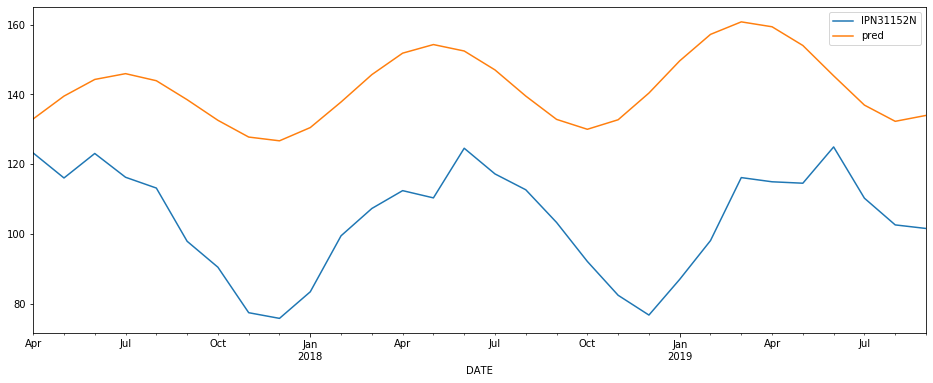

In [144]:
test.plot(figsize = (16,6))

## Forecasting

## Scaling the entire data set 

In [145]:
full_scalar = MinMaxScaler()

In [146]:
data_scaled = full_scalar.fit_transform(frozen_data)

In [147]:
data_scaled.shape

(573, 1)

In [148]:
forecast = []
period = length
bb = train_scaled[]

SyntaxError: invalid syntax (<ipython-input-148-8619fcf47231>, line 3)